<a href="https://colab.research.google.com/github/mlabonne/Graph-Neural-Network-Course/blob/main/3_GraphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphSAGE
> Chapter 3 of the [Graph Neural Network Course](https://github.com/mlabonne/Graph-Neural-Network-Course)

❤️ Created by [@maximelabonne](https://twitter.com/maximelabonne).

Companion notebook to execute the code from the following article: https://mlabonne.github.io/blog/graphsage/

In [ ]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

     |████████████████████████████████| 7.9 MB 2.3 MB/s 
     |████████████████████████████████| 3.5 MB 233 kB/s 


# Dataset

In [ ]:
import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


# Mini-batching

Subgraph 0: Data(x=[386, 500], edge_index=[2, 442], y=[386], train_mask=[386], val_mask=[386], test_mask=[386], batch_size=16)
Subgraph 1: Data(x=[260, 500], edge_index=[2, 311], y=[260], train_mask=[260], val_mask=[260], test_mask=[260], batch_size=16)
Subgraph 2: Data(x=[280, 500], edge_index=[2, 316], y=[280], train_mask=[280], val_mask=[280], test_mask=[280], batch_size=16)
Subgraph 3: Data(x=[190, 500], edge_index=[2, 228], y=[190], train_mask=[190], val_mask=[190], test_mask=[190], batch_size=12)


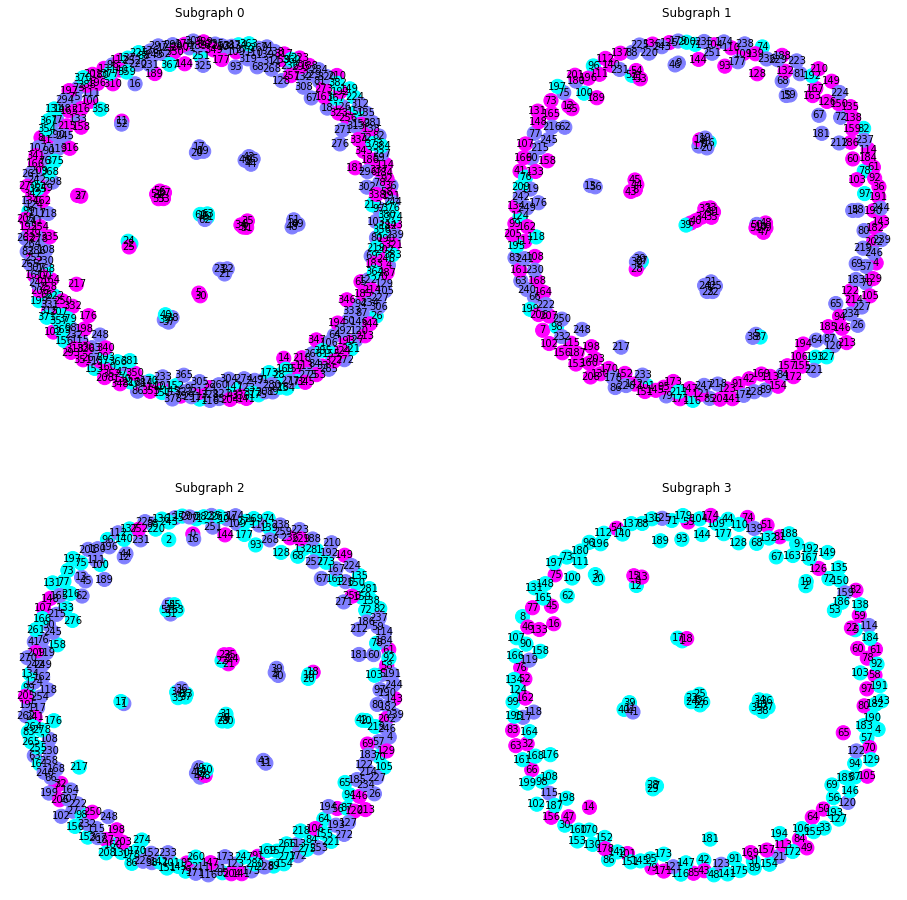

In [ ]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, ['221', '222', '223', '224'])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

# Plot node degrees

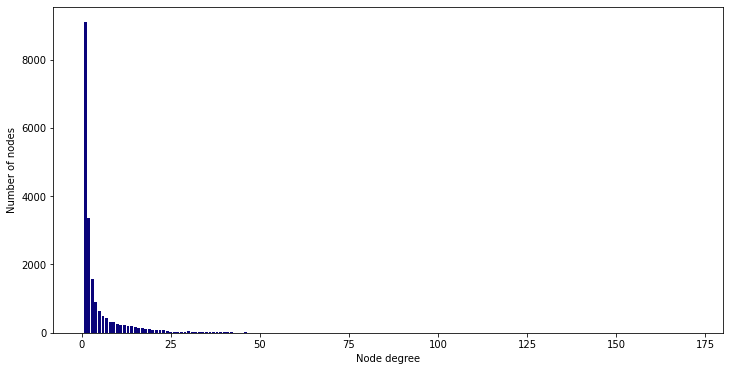

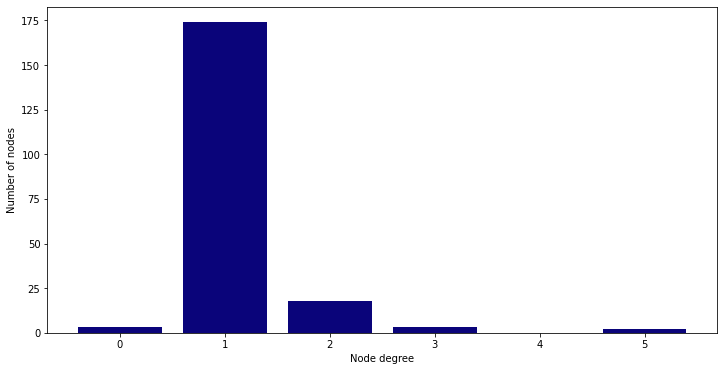

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

# Implement GraphSage vs. GAT vs. GCN

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        _, out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
            
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GraphSAGE

In [ ]:
%%time
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64)
  (sage2): SAGEConv(64, 3)
)
Epoch   0 | Train Loss: 0.332 | Train Acc:  30.24% | Val Loss: 1.13 | Val Acc: 18.33%
Epoch  10 | Train Loss: 0.020 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 72.50%
Epoch  20 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 73.17%
Epoch  30 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.49 | Val Acc: 79.96%
Epoch  40 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 63.33%
Epoch  50 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 75.56%
Epoch  60 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.77 | Val Acc: 71.25%
Epoch  70 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.50 | Val Acc: 79.79%
Epoch  80 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.54 | Val Acc: 76.74%
Epoch  90 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.65 | Val Acc: 76.74%
Epoch 100 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.49 | V

# Train GCN

In [ ]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 64)
  (gcn2): GCNConv(64, 3)
)
Epoch   0 | Train Loss: 1.098 | Train Acc:  33.33% | Val Loss: 1.10 | Val Acc: 32.20%
Epoch  10 | Train Loss: 0.736 | Train Acc:  91.67% | Val Loss: 0.87 | Val Acc: 74.60%
Epoch  20 | Train Loss: 0.400 | Train Acc:  96.67% | Val Loss: 0.67 | Val Acc: 73.80%
Epoch  30 | Train Loss: 0.214 | Train Acc:  93.33% | Val Loss: 0.61 | Val Acc: 76.80%
Epoch  40 | Train Loss: 0.124 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 75.60%
Epoch  50 | Train Loss: 0.092 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.095 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 76.80%
Epoch  70 | Train Loss: 0.087 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.20%
Epoch  80 | Train Loss: 0.085 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 75.60%
Epoch  90 | Train Loss: 0.088 | Train Acc:  98.33% | Val Loss: 0.62 | Val Acc: 76.60%
Epoch 100 | Train Loss: 0.074 | Train Acc:  98.33% | Val Loss: 0.63 | Val Acc: 75

# Train GAT

In [ ]:
%%time
# Create GAT
gat = GAT(dataset.num_features, 64, dataset.num_classes)
print(gat)

# Train
gat.fit(data, 200)

# Test
print(f'\nGAT test accuracy: {test(gat, data)*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(500, 64, heads=8)
  (gat2): GATv2Conv(512, 3, heads=8)
)
Epoch   0 | Train Loss: 3.174 | Train Acc:   1.67% | Val Loss: 3.18 | Val Acc: 1.00%
Epoch  10 | Train Loss: 0.707 | Train Acc:  86.67% | Val Loss: 0.87 | Val Acc: 71.00%
Epoch  20 | Train Loss: 0.363 | Train Acc:  93.33% | Val Loss: 0.64 | Val Acc: 77.20%
Epoch  30 | Train Loss: 0.178 | Train Acc:  96.67% | Val Loss: 0.58 | Val Acc: 78.40%
Epoch  40 | Train Loss: 0.101 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 78.40%
Epoch  50 | Train Loss: 0.087 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 77.80%
Epoch  60 | Train Loss: 0.072 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 78.40%
Epoch  70 | Train Loss: 0.076 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.40%
Epoch  80 | Train Loss: 0.064 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 76.40%
Epoch  90 | Train Loss: 0.058 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.20%
Epoch 100 | Train Loss: 0.062 | Train Acc: 100.00% | Val Lo